### Import Dependencies

In [1]:
from brickschema import Graph
import matplotlib.pyplot as plt
import pandas as pd
import rdflib

import dbmanager

2024-10-08:14:35:38,527 WARNING [__init__.py:22] sqlalchemy not installed. SQL-backed graph support will not be available. Try 'pip install brickschema[persistence]' to install it.


No module named 'pkg_resources'


### Setup Paths to Files

In [2]:
building_ttl_file = '../../datasets/bts_site_b_train/Site_B_cleaned.ttl'
data_zip_file = '../../datasets/bts_site_b_train/train.zip'
mapping_csv_file = '../../datasets/bts_site_b_train/mapper_TrainOnly.csv'

### Load and Expand the Building Model

In [3]:
g = Graph(load_brick=True) # should actually loading the v1.2.1 brick schema
g.load_file(building_ttl_file)
print(f'Building model has {len(g)} triples')

Building model has 52457 triples


In [4]:
g.expand(profile='rdfs') # inference using RDFS reasoning
print(f'Expanded building model has {len(g)} triples')

Expanded building model has 89052 triples


In [5]:
g.expand(profile='shacl') # infererence using Brick classes from Brick tags
print(f'Expanded building model has {len(g)} triples')

2024-10-08:14:36:17,306 WARNING [graph.py:293] Validation Report
Conforms: False
Results (24):
Constraint Violation in OrConstraintComponent (http://www.w3.org/ns/shacl#OrConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ rdf:type rdfs:Resource ; sh:or ( [ rdf:type rdfs:Resource ; sh:class brick:Room ] [ rdf:type rdfs:Resource ; sh:class brick:Space ] [ rdf:type rdfs:Resource ; sh:class brick:Zone ] ) ; sh:path brick:hasPart ]
	Focus Node: p33f3e0c2_f2cd_471c_b5a0_4655c2bd4623:ef790dae_bb9b_4cd7_a52c_ea35841f02dd
	Value Node: p33f3e0c2_f2cd_471c_b5a0_4655c2bd4623:506f355b_ec0d_4763_8082_5d022dcf6153.6af9698e_b72b_48d7_b864_9a0d518ec3b1
	Result Path: brick:hasPart
	Message: Node p33f3e0c2_f2cd_471c_b5a0_4655c2bd4623:506f355b_ec0d_4763_8082_5d022dcf6153.6af9698e_b72b_48d7_b864_9a0d518ec3b1 does not conform to one or more shapes in [ rdf:type rdfs:Resource ; sh:class brick:Room ] , [ rdf:type rdfs:Resource ; sh:class brick:Space ] , [ rdf:type rdfs:Resource ; sh:class brick:Zo

Expanded building model has 94491 triples


### Load the Timeseries Data

In [6]:
db = dbmanager.DBManager(data_zip_file, mapping_csv_file)
print(f'Dataset contains {len(db)} time series')

Dataset contains 668 time series


### Helper Functions

In [7]:
def get_room_temp_stream_ids(room_uri):
    room_temp_query = '''
        SELECT ?ats_sid ?atsp_sid WHERE  {
            ?ats  a                 brick:Air_Temperature_Sensor .
            ?ats  brick:isPointOf   ?room_uri .
            ?ats  senaps:stream_id  ?ats_sid .
            ?atsp a                 brick:Room_Air_Temperature_Setpoint .
            ?atsp brick:isPointOf   ?room_uri .
            ?atsp senaps:stream_id  ?atsp_sid .
        }
    '''

    results = g.query(room_temp_query, initBindings={'room_uri': room_uri})
    return results.bindings[0]

In [8]:
def get_outside_temp_stream_id():
    outside_temp_query = '''
        SELECT ?ats_sid WHERE  {
            ?ats  a                 brick:Outside_Air_Temperature_Sensor .
            ?ats  brick:isPointOf   ?loc .
            ?loc   a                brick:Weather_Station .
            ?ats  senaps:stream_id  ?ats_sid .
        }
    '''

    results = g.query(outside_temp_query)
    return results.bindings[0]

In [9]:
def get_daily_median(df):
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = df['time'].dt.date
    df = df.groupby(['date', 'label'])['value'].median().unstack()
    return df

In [10]:
def get_room_class(room_uri):
    room_type_query = '''
        SELECT ?class WHERE {
            ?room_uri  a                ?class .
            ?class     rdfs:subClassOf  brick:Room .
        }
    '''

    results = g.query(room_type_query, initBindings={'room_uri': room_uri})
    return results.bindings[0]['class'].replace('https://brickschema.org/schema/Brick#', '')

### Get Rooms with Temperature Measurements

In [11]:
def get_rooms_with_temp():
    rooms_with_temp_query = '''
        SELECT DISTINCT ?class ?loc ?ats ?atsp WHERE  {
            ?ats    a                 brick:Air_Temperature_Sensor .
            ?atsp   a                 brick:Room_Air_Temperature_Setpoint .
            ?ats    brick:isPointOf   ?loc .
            ?atsp   brick:isPointOf   ?loc .
            ?loc    a                 brick:Room .
            ?loc    a                 ?class   .
            ?class  rdfs:subClassOf   brick:Room .
        }
        ORDER BY ?class ?loc
    '''

    return g.query(rooms_with_temp_query)

In [12]:
rooms_with_temp = get_rooms_with_temp()
for row in rooms_with_temp:
    print(row)

(rdflib.term.URIRef('https://brickschema.org/schema/Brick#Conference_Room'), rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#3b373634_2461_4b61_8bcb_068c12b7e1a8.6af9698e_b72b_48d7_b864_9a0d518ec3b1'), rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#554f7ba1_7232_4a12_a2b6_0954976ff3b9.8869a237_11bc_44a4_b0c3_4c1689effddd'), rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#554f7ba1_7232_4a12_a2b6_0954976ff3b9.a0812711_4b5c_45db_8f28_4addba2e1f0a'))
(rdflib.term.URIRef('https://brickschema.org/schema/Brick#Conference_Room'), rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#3b3

### Plot Room Temperature

In [13]:
def plot_daily_room_temp(room_uri):
    outside_temp_stream_id = get_outside_temp_stream_id()
    room_temp_stream_ids = get_room_temp_stream_ids(room_uri)

    outside_air_temp_df = db.get_stream(outside_temp_stream_id['ats_sid'])
    inside_air_temp_df = db.get_stream(room_temp_stream_ids['ats_sid'])
    room_air_temp_setpoint_df = db.get_stream(room_temp_stream_ids['atsp_sid'])

    outside_median_df = get_daily_median(outside_air_temp_df)
    inside_median_df = get_daily_median(inside_air_temp_df)
    setpoint_median_df = get_daily_median(room_air_temp_setpoint_df)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(inside_median_df.index, inside_median_df[inside_median_df.columns[0]], label=inside_median_df.columns[0], marker=',')
    ax.plot(outside_median_df.index, outside_median_df[outside_median_df.columns[0]], label=outside_median_df.columns[0], color='g', marker=',', alpha=0.5)
    ax.plot(setpoint_median_df.index, setpoint_median_df[setpoint_median_df.columns[0]], label=setpoint_median_df.columns[0], color='r', marker=',', alpha=0.5)

    title = get_room_class(room_uri).replace('_', ' ') + ' Daily Median Temperature'
    subtitle = f'{room_uri}'
    subtitle = 'URI: ' + subtitle[subtitle.find('#')+1:]

    # plt.suptitle(title, y=1.05, fontsize=18)
    plt.suptitle(title, fontsize=12, y=0.97)
    plt.title(subtitle, fontsize=8)
    plt.xlabel('Date')
    plt.ylabel('Daily Median Temperature')
    plt.legend()
    plt.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

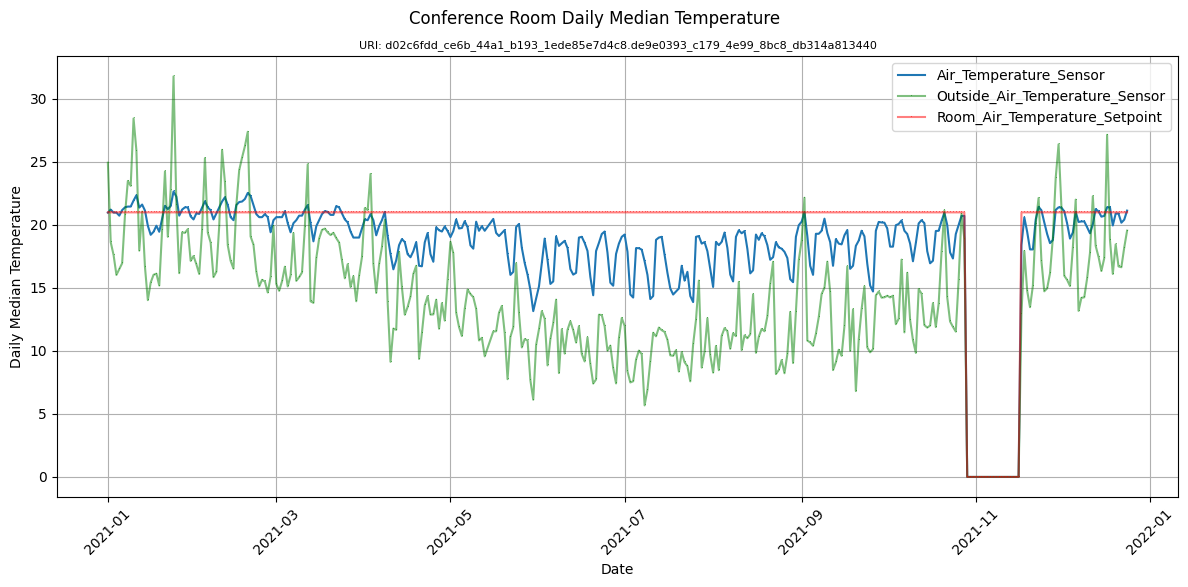

In [14]:
plot_daily_room_temp(rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#d02c6fdd_ce6b_44a1_b193_1ede85e7d4c8.de9e0393_c179_4e99_8bc8_db314a813440'))

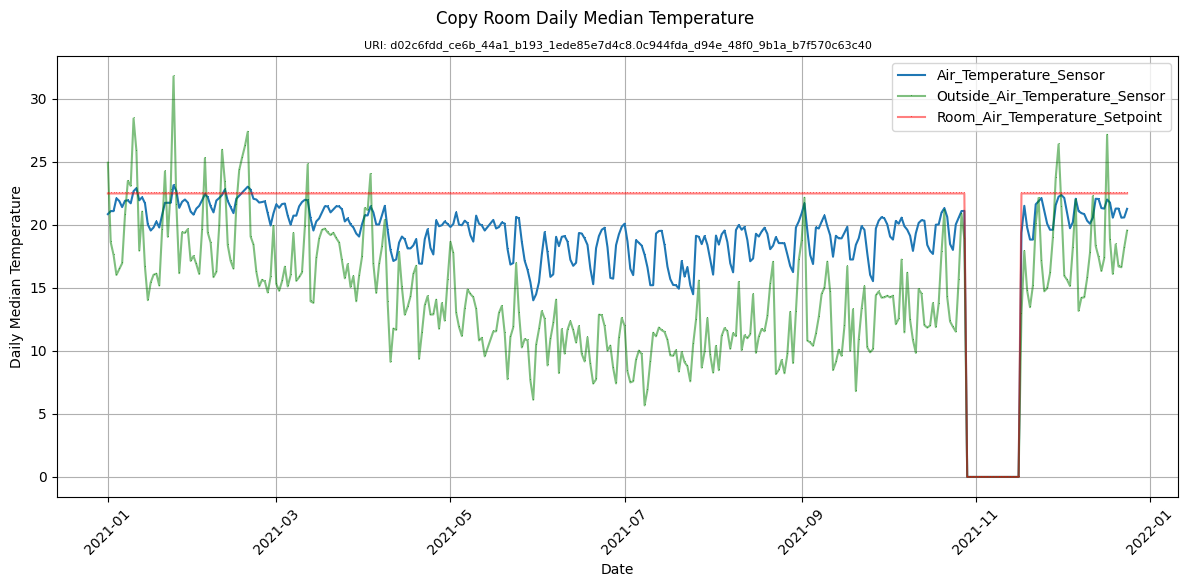

In [15]:
plot_daily_room_temp(rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#d02c6fdd_ce6b_44a1_b193_1ede85e7d4c8.0c944fda_d94e_48f0_9b1a_b7f570c63c40'))

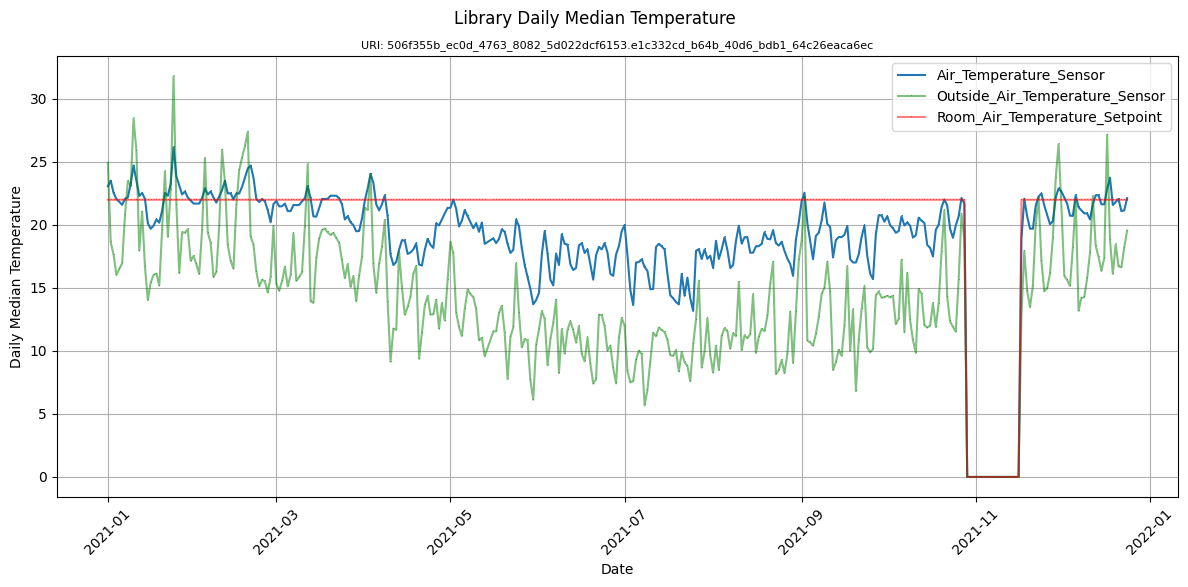

In [16]:
plot_daily_room_temp(rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#506f355b_ec0d_4763_8082_5d022dcf6153.e1c332cd_b64b_40d6_bdb1_64c26eaca6ec'))
